# Step 1 - Modern waves and tides
In this code, we extract waves and tides for the Area of Interest (AOI) from global datasets / models. We create some descriptive graphics and export the wave and tidal data for runup calculations. To run this code, you can setup an environment in conda using the *waves_tides.yml* file in the 'environments' folder.

## 1.Folder creation
First, we create the folders needed to store the results

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import copernicusmarine
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from astropy.time import Time, TimeDelta
import pandas as pd

In [4]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        if os.listdir(folder_path):
            print(f"Folder '{folder_path}' is not empty. Deleting contents...")
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                try:
                    if os.path.isfile(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
            print(f"Contents of folder '{folder_path}' deleted.")
        else:
            print(f"Folder '{folder_path}' already exists and is empty.")

# Example usage:
outdata_path = 'output/data'
create_folder_if_not_exists(outdata_path)
images_path = 'output/images'
create_folder_if_not_exists(images_path)


Folder 'output/data' is not empty. Deleting contents...
Contents of folder 'output/data' deleted.
Folder 'output/images' is not empty. Deleting contents...
Contents of folder 'output/images' deleted.


## 2.Area of Interest
Then, we define the Area Of Interest in lat/lon. The script calculates automatically the center of the bounding box, that will be then used to extract wave and tide timeseries. 

In [5]:
min_lon=-69
max_lon=-62
min_lat=-48
max_lat=-44

# Virtual Buoy
#Calculate average coordinates
target_lon=np.mean([min_lon,max_lon])
target_lat=np.mean([min_lat,max_lat])

lon_SOI=-67.4328181
lat_SOI=-46.55812801

## 3.Download wave data
The first step is to retrieve modern wave data. We use the GLOBAL_REANALYSIS_WAV_001_032 product from COPERNICUS. The GLOBAL_REANALYSIS_WAV_001_032 for the global wave reanalysis describes past sea states from 15/01/1993 to 30/04/2023. To get this data, the user needs to register here: https://data.marine.copernicus.eu/

> DOI (product): https://doi.org/10.48670/moi-00022

> Law-Chune, S., Aouf, L., Dalphinet, A. et al. WAVERYS: a CMEMS global wave reanalysis during the altimetry period. Ocean Dynamics 71, 357–378 (2021). https://doi.org/10.1007/s10236-020-01433-w

You need to run this step only once, the data will be saved. If you already ran this part, **skip to section 4**.

First, we need to make sure to insert the login credentials to the Copernicus Marine Services.
**This needs to be run only the first time you run this script, the user and passord are saved into the system.**

In [4]:
copernicusmarine.login()

username:

Abort: 

The next step is the interrogation of the Copernicus dataset. We download wave data from 1994 to 2021.
We extract the following attributes:

1) **VHM0 [m]** - Spectral significant wave height (Hm0)
2) **VTPK [s]** - Wave period at spectral peak / peak period (Tp)
3) **VMDR [degree]** - Mean wave direction from (Mdir)

Querying and downloading the data might take a long time depending on your connection.
**If you have already done this step and the file has been saved on your machine, you can skip this step**

In [9]:
def clear_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        os.makedirs(folder_path)
    else:
        print(f'The folder {folder_path} does not exist.')

# Example usage
folder_path = 'output/data/'
clear_folder(folder_path)

copernicusmarine.subset(
  dataset_id="cmems_mod_glo_wav_my_0.2deg_PT3H-i",
  dataset_version="202311",
  minimum_longitude=min_lon,
  maximum_longitude=max_lon,
  minimum_latitude=min_lat,
  maximum_latitude=max_lat,
  start_datetime="1993-01-01T00:00:00",
  end_datetime="2024-01-31T00:00:00",
  output_filename = "waves_copernicus.nc",
  output_directory = "output/data")


INFO - 2024-05-25T09:12:44Z - You forced selection of dataset version "202311"
INFO - 2024-05-25T09:12:44Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-05-25T09:12:45Z - Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-05-25T09:12:46Z - Some or all of your subset selection [1993-01-01 00:00:00, 2024-01-31 00:00:00] for the time dimension  exceed the dataset coordinates [1993-01-01 00:00:00, 2023-04-30 21:00:00]
INFO - 2024-05-25T09:12:46Z - Downloading using service arco-time-series...
INFO - 2024-05-25T09:12:47Z - <xarray.Dataset>
Dimensions:    (time: 88616, latitude: 21, longitude: 36)
Coordinates:
  * latitude   (latitude) float32 -48.0 -47.8 -47.6 -47.4 ... -44.4 -44.2 -44.0
  * longitude  (longitude) float32 -69.0 -68.8 -68.6 -68.4 ... -62.4 -62.2 -62.0
  * time       (time) datetime64[ns] 1993-01-01 ... 2023-04-30T21:00:00
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 da

  y


INFO - 2024-05-25T09:12:49Z - Writing to local storage. Please wait...


100%|██████████| 23360/23360 [05:53<00:00, 66.05it/s] 

INFO - 2024-05-25T09:18:46Z - Successfully downloaded to output/data/waves_copernicus.nc


PosixPath('output/data/waves_copernicus.nc')

## 4.Wave data analysis
We use xarray to read the netcdf file we just downloaded.

In [10]:
wav_nc = (folder_path+'waves_copernicus.nc')
wav_ds = xr.open_dataset(wav_nc)
wav_ds

<xarray.Dataset>
Dimensions:    (time: 88616, latitude: 21, longitude: 36)
Coordinates:
  * latitude   (latitude) float32 -48.0 -47.8 -47.6 -47.4 ... -44.4 -44.2 -44.0
  * longitude  (longitude) float32 -69.0 -68.8 -68.6 -68.4 ... -62.4 -62.2 -62.0
  * time       (time) datetime64[ns] 1993-01-01 ... 2023-04-30T21:00:00
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 ...
    VHM0_SW1   (time, latitude, longitude) float32 ...
    VHM0_SW2   (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    ...         ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VTM01_SW2  (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
    VTPK       (time, latitude, longitude) float32 ...
Attributes: (12/31)
    CDI:                           Climate Data Interface version 1.9.8 (http...
    CDO:                           Climate Data Operators version 1.9.8 (http...
    Conventions:                   CF-1.6
    area:                          GLO
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    references:                    http://marine.copernicus.eu
    time_coverage_end:             20230430-21:00:00
    time_coverage_start:           20230430-00:00:00
    title:                         Mean fields from global wave model MFWAM o...
    version:                       1.2
    copernicusmarine_version:      1.2.3

The next step is to extract a timeseries containing wave data and transforming it into a pandas dataframe.

In [11]:
# Select the data at the specified location
location_data = wav_ds.sel(latitude=target_lat, longitude=target_lon, method='nearest')

# Extract the variables you're interested in
variables = ['VHM0', 'VTPK', 'VMDR']
location_data = location_data[variables]

# Convert the xarray dataset to a Pandas DataFrame
waves_df = location_data.to_dataframe().reset_index().drop(['latitude', 'longitude'], axis=1)


Now, we plot the data to make sure there are no outliers or errors.

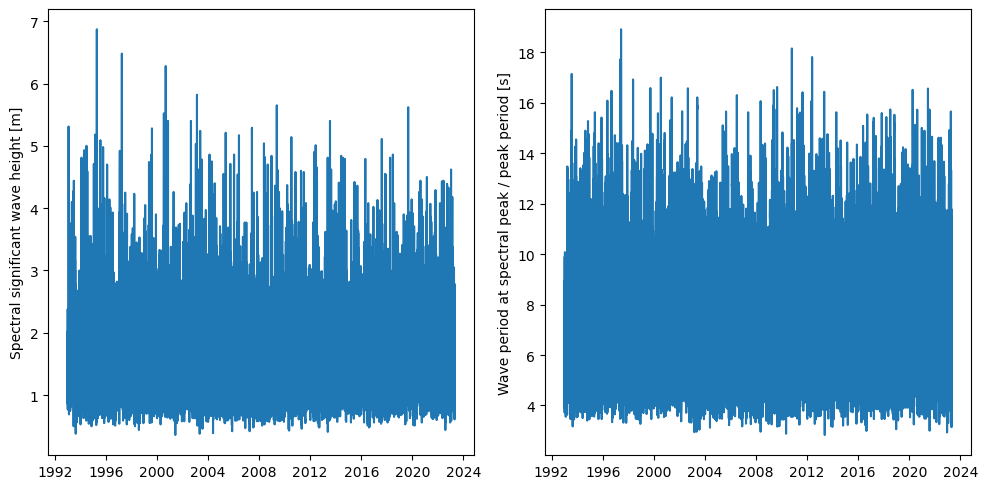

In [12]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(waves_df['time'], waves_df['VHM0'], label='VHM0')
axes[0].set_ylabel('Spectral significant wave height [m]')
axes[1].plot(waves_df['time'], waves_df['VTPK'], label='VTPK')
axes[1].set_ylabel('Wave period at spectral peak / peak period [s]')
plt.tight_layout()
plt.savefig(os.path.join(images_path,'Hs_Tp_timeseries.jpg'),dpi=500)
plt.show()

Now, we filter the wave data in a way that only waves directed towards the coast are kept in the dataframe.

In [13]:
# Change wave angles to keep only shore-perpendicular waves
min_wave_angle=45
max_wave_angle=135

waves_filter = waves_df[(waves_df['VMDR'] >= min_wave_angle) & (waves_df['VMDR'] <= max_wave_angle)]
waves_filter.reset_index(drop=True, inplace=True)

We then make a wave rose, to make sure that only the waves coming from offshore have been kept in the dataset.

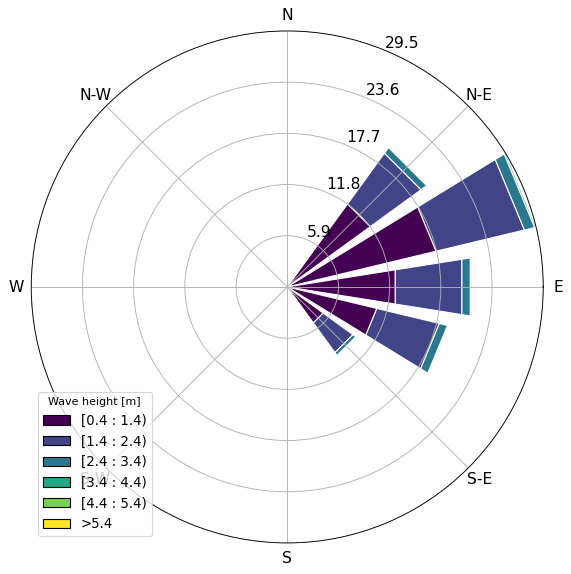

In [14]:
ax = WindroseAxes.from_ax()
ax.bar(waves_filter['VMDR'], waves_filter['VHM0'], normed=True, opening=0.8, edgecolor='white')
ax.legend(title='Wave height [m]', fontsize='large')
ax.tick_params(axis='x', labelsize=14)  # Adjust the font size as needed
ax.tick_params(axis='y', labelsize=14)  # Adjust the font size as needed
plt.savefig(os.path.join(images_path,'Windrose_HS_filtered.pdf'),transparent=True,dpi=500)
plt.show()

For comparison, we also plot the complete windrose.

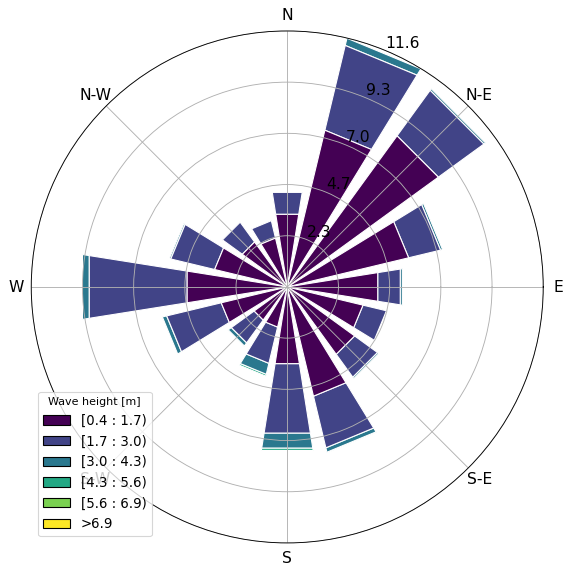

In [15]:
ax = WindroseAxes.from_ax()
ax.bar(waves_df['VMDR'], waves_df['VHM0'], normed=True, opening=0.8, edgecolor='white')
ax.legend(title='Wave height [m]', fontsize='large')
ax.tick_params(axis='x', labelsize=14)  # Adjust the font size as needed
ax.tick_params(axis='y', labelsize=14)  # Adjust the font size as needed
plt.savefig(os.path.join(images_path,'Windrose_HS_unfiltered.pdf'),transparent=True,dpi=500)
plt.show()

Then we plot the wave climate in terms of significant wave height and period.

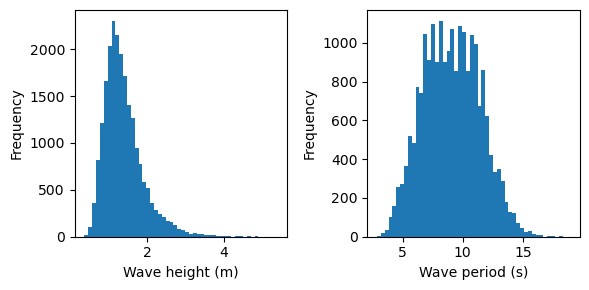

In [16]:
fig_size = (6, 3)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

axs[0].hist(waves_filter['VHM0'], bins=50, orientation='vertical')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Wave height (m)')

axs[1].hist(waves_filter['VTPK'], bins=50, orientation='vertical')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Wave period (s)')

plt.tight_layout()
plt.savefig(os.path.join(images_path,'wave_climate.jpg'),dpi=500)

plt.show()

We then plot a map with the average wave height and the point of extraction of wave and tidal data defined above. 

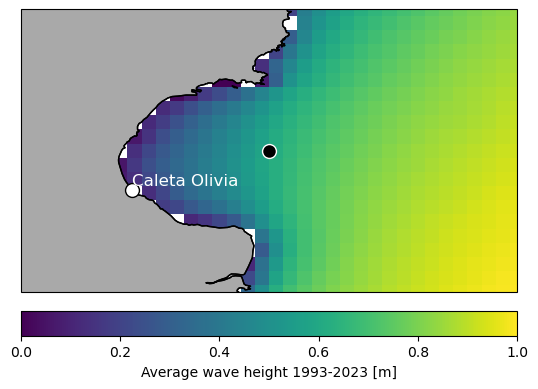

In [17]:
# Calculate the average of the variable "VHM0"
average_VHM0 = wav_ds['VHM0'].mean(dim='time')
# Create a map using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([average_VHM0.longitude.min(), average_VHM0.longitude.max(),
               average_VHM0.latitude.min(), average_VHM0.latitude.max()])
# Add land and coastline features
ax.add_feature(cfeature.LAND, edgecolor='black',facecolor='darkgray',zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=2)
# Plot the average VHM0 on the map
average_VHM0.plot(ax=ax, cmap='viridis', add_colorbar=False,zorder=1)
# Mark the target point with a red dot
ax.plot(target_lon, target_lat, 'ko', markersize=10, markeredgecolor='white', markeredgewidth=1, transform=ccrs.PlateCarree(),zorder=3)
#ax.text(target_lon + 0.05, target_lat + 0.05, 'Virtual wave buoy', fontsize=12, color='white', transform=ccrs.PlateCarree(),zorder=3)
ax.plot(lon_SOI, lat_SOI, 'wo', markersize=10, markeredgecolor='black', markeredgewidth=1, transform=ccrs.PlateCarree(),zorder=3)
ax.text(lon_SOI, lat_SOI + 0.08, 'Caleta Olivia', fontsize=12, color='white', transform=ccrs.PlateCarree(),zorder=3)

# Add colorbar
cb = plt.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('Average wave height 1993-2023 [m]')
plt.savefig(os.path.join(images_path,'avg_Hs_map.pdf'),dpi=500)
plt.show()

## 5.Tidal model data
The next step is to retrieve tidal data. for this purpose, we use the FES2014 tidal model and the pyTMD software (https://doi.org/10.5281/zenodo.5555395). The FES2014 model can be downloaded (upon registration) from the Aviso+ website (https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html) and should be placed in the "aviso-fes-main" folder, within the project folder.  

>Lyard F., L. Carrere, M. Cancet, A. Guillot, N. Picot: FES2014, a new finite elements tidal model for global ocean, in preparation, to be submitted to Ocean Dynamics in 2016.

>Carrere L., F. Lyard, M. Cancet, A. Guillot, N. Picot: FES 2014, a new tidal model - Validation results and perspectives for improvements, presentation to ESA Living Planet Conference, Prague 2016.

>T. C. Sutterley, T. Markus, T. A. Neumann, M. R. van den Broeke, J. M. van Wessem, and S. R. M. Ligtenberg, "Antarctic ice shelf thickness change from multimission lidar mapping", The Cryosphere, 13, 1801-1817, (2019). doi: 10.5194/tc-13-1801-2019

>L. Padman, M. R. Siegfried, H. A. Fricker, "Ocean Tide Influences on the Antarctic and Greenland Ice Sheets", Reviews of Geophysics, 56, 142-184, (2018). doi: 10.1002/2016RG000546

In [18]:
import datetime
import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities

Before starting, define some parameters:
- Folder where the FES2014 model is stored
- Frequency of tidal data extraction
- Latitude and longitude of tidal data extraction (use a point slightly offshore)

In [19]:
folder='aviso-fes-main/data/'
forecast_every_minutes = 15 #minutes
lat_Tide=-46.430275
lon_Tide=-67.268643

In [20]:
current_path = os.getcwd()
full_path = os.path.join(current_path, folder)
model = pyTMD.io.model(full_path,format='netcdf',compressed=False).elevation('FES2014')
# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = datetime.date(1993, 1, 1)
time_range = 365 * 33 * 24 * 60
# Generate an array for the time range with a step size of 15 minutes
minutes = np.arange(0, time_range, forecast_every_minutes)
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,YMD.day, minute=minutes)
# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])
constituents = pyTMD.io.FES.read_constants(model.model_file,
        type=model.type, version=model.version,
        compressed=model.compressed)
c = model.constituents
# interpolate delta times from calendar dates to tide time
DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)                                  
LAT,LON = np.copy([lat_Tide,lon_Tide])
amp,ph = pyTMD.io.FES.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)
# predict tidal elevations at time 1 and infer minor corrections
TIDE = pyTMD.predict.time_series(tide_time, hc, c,deltat=DELTAT, corrections=model.format)
MINOR = pyTMD.predict.infer_minor(tide_time, hc, c,deltat=DELTAT, corrections=model.format)
TIDE.data[:] += MINOR.data[:]
def mjd_relative_to_utc(mjd_relative_array, reference_mjd):
    # MJD array relative to a reference point to Astropy Time object
    t = Time(reference_mjd + mjd_relative_array, format='mjd', scale='utc')
    # Extracting calendar dates
    calendar_dates = t.iso
    return calendar_dates
reference_mjd = 48622
# Convert relative MJD array to calendar dates
calendar_dates = mjd_relative_to_utc(tide_time, reference_mjd)

We then make a dataframe with the tidal data, making sure that the dates and times are stored correctly. We also create a datafile that can be used as input in the NOAA tidal datum calculator: https://access.co-ops.nos.noaa.gov/datumcalc/CalculateDatums

In [22]:
tides_df = pd.DataFrame({'Calendar Date (UTC)': calendar_dates,'TIDE_data': TIDE.data})
tides_df['Calendar Date (UTC)'] = pd.to_datetime(tides_df['Calendar Date (UTC)'], format='%Y-%m-%d %H:%M:%S.%f')

tides_NOAA = pd.DataFrame({'Calendar Date (UTC)': calendar_dates,'TIDE_data': TIDE.data})
# Format 'Calendar Date (UTC)' column
tides_NOAA['Calendar Date (UTC)'] = tides_df['Calendar Date (UTC)'].dt.strftime('%m/%d/%Y %H:%M')

# Export DataFrame to CSV
tides_NOAA.to_csv(os.path.join(outdata_path,'tides_NOAA.csv'), float_format='%.3f',index=False)

We plot the tidal data to make sure there are no outliers or errors.

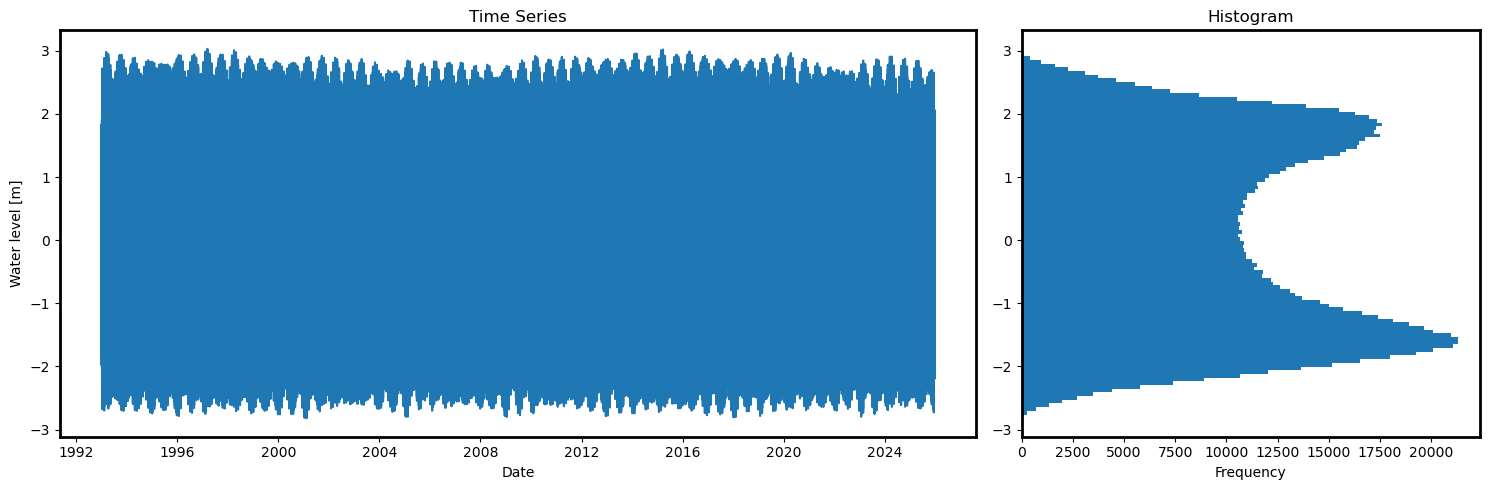

In [23]:
fig_size = (15, 5)
fig, axs = plt.subplots(1, 2, figsize=fig_size, gridspec_kw={'width_ratios': [2, 1]})

axs[0].plot(tides_df['Calendar Date (UTC)'], tides_df['TIDE_data'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Water level [m]')
axs[0].set_title('Time Series')

axs[1].hist(tides_df['TIDE_data'], bins=100, orientation='horizontal')
axs[1].set_xlabel('Frequency')
axs[1].set_title('Histogram')

plt.tight_layout()
plt.savefig(os.path.join(images_path,'tides.jpg'),dpi=500)

plt.show()


## 6.Export wave and tide data to CSV
Now, we export the data so they can be used in the runup calculations.

In [24]:
# Format the date column
tides_df['dates'] = pd.to_datetime(tides_df['Calendar Date (UTC)']).dt.strftime('%Y-%m-%d %H:%M:%S.%f+00:00')
# Format the tide column to 3 decimal places
tides_df['tide'] = tides_df['TIDE_data'].round(3)
tides_df.drop(columns=['Calendar Date (UTC)','TIDE_data'],inplace=True)
tides_df.to_csv(os.path.join(outdata_path,'tides.csv'), index=False)
waves_filter.to_csv(os.path.join(outdata_path,'waves_filtered.csv'), index=False)
waves_df.to_csv(os.path.join(outdata_path,'waves_complete.csv'), index=False)

## Next step
Now, it is possible to run the notebook '**Step 2 - Beach slope.ipynb**'

## Acknowledgments
This project has received funding from the European Research Council (ERC) under the European Union's Horizon 2020 research and innovation programme (grant agreement no. 802414 to Alessio Rovere). 

In this script, we use E.U. Copernicus Marine Service Information, see citations in the jupyter notebook. This script contains work and contributions from the scientific community. The Tidal Model Driver (TMD) Matlab Toolbox was developed by Laurie Padman, Lana Erofeeva and Susan Howard. The tidal model FES2014 was generated using AVISO+ Products.

Parts of this code have been developed with the help of ChatGPT. However, they have been cross-validated by human intervention to ensure reliability.